# Notebook Contents


In [11]:
from IPython.core.display import HTML

In [12]:
import os
import pyodbc 
import pandas             as pd
import numpy              as np
import seaborn            as sns
import matplotlib.pyplot  as plt

# Comment this if the data visualisations doesn't work
%matplotlib inline
plt.style.use('bmh')

## Connection string
To make connection with DataBase (SQL, Access, Excel, etc.) required library PYODBC

More good samples how to use can finde in:
    [Wiki](https://github.com/mkleehammer/pyodbc/wiki)

In [13]:
# required pyodbc

conn_str = (
    r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
    r'DBQ=Z:\Swedwood KR\Department Production\Technologist\BOM\DB\Inventories_v3_be.accdb;'
    r'UID=user;'
    r'PWD=;'
    )
cnxn = pyodbc.connect(conn_str)

In [14]:
sql = """   
     SELECT 
        ITEMCHAR.WC as WorckCenter,
        ITEMCHAR.ITEM_ID as ProductAGR,
        ITEMCHAR.ITEM_NAME as ProductName,
        ITEMCHAR.NPC_MAX as NPC, 
        ITEMCHAR.QTY_BLANK_1 as Parts,
        ITEMCHAR.MARSRUTAS as Path,
        ITEMCHAR.WIDTH_1 as Width,
        ITEMCHAR.LENGHT_1 as Lenght,      
        ITEMCHAR.Liftas_Past as LiftPushSpeed,
        ITEMCHAR.Liftas_nuos_veikimas as LiftRegularSpeed,
        ITEMCHAR.pas_stal_iejimas as RT1EntranceSpeed,
        ITEMCHAR.pas_stal_isejimas as RT1ExitSpeed,     
        ITEMCHAR.[2_pas_stal_iejimas] as RT2EntranceSpeed,
        ITEMCHAR.[2_pas_stal_isejimas] as RT2ExitSpeed,
        ITEMCHAR.[1_krast_stak_pastuma] as EM1PushSpeed,
        ITEMCHAR.[1_krast_stak_Ciklas] as EM1PushCycle,
        ITEMCHAR.[2_krast_stak_pastuma] as EM2PushSpeed, 
        ITEMCHAR.[2_krast_stak_Ciklas] as EM2PushCycle,  
        ITEMCHAR.[1_krast_stak_Kumstelio_sk] as Position,        
        
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')+2) +
            COLLORS.COLINX +
            RIGHT(ITEM_ID, LEN(ITEM_ID)-(inStr(ITEM_ID, '-')+3)) as Product,
            
        LEFT(ITEM_ID, inStr(ITEM_ID, '-')-1) as BR 
        
    FROM ITEMCHAR, COLLORS
    WHERE 
        ITEMCHAR.COLOR_INDEX = COLLORS.UNKNOWN AND 
        WC in (12010) AND
        ITEMCHAR.archivuotas = False
        
    """
data = pd.read_sql(sql,cnxn);

# Data description:

* **WorckCenter** - Worck center (Mashine) ID number in ouer system;
* **ProductAGR** - Product ID with eliminated color parameter where suposte be color here 'X' *example: BR3-ITX104 color can be W (White), B (Black), O (Oack) or any else*;
* **Product**
* **BR** - Basic group of operation level;
* **ProductName**
* **NPC** - Name Plate Capacity;
* **Parts** - Some raw product whe need cut this indicator shows how many items we have in this raw product;
* **Path**
* **Width**
* **Lenght**      
* **LiftPushSpeed**
* **LiftRegularSpeed**
* **RT1EntranceSpeed**
* **RT1ExitSpeed**  
* **RT2EntranceSpeed**
* **RT2ExitSpeed**
* **EM1PushSpeed**
* **EM1PushCycle**
* **EM2PushSpeed**
* **EM2PushCycle**  
* **Position**

# Data Mungy *(Duomenų paruošimas (Pre-processing))*

* Transform the data;
* Normalize the data;
* Eliminate outliers

Check data sets for missing values

In [15]:
print('Bad rows (with missing values) caunt: ', data.shape[0]-data.dropna().shape[0],
     '\nRaw data shape: ', data.shape,
     '\nClean data shape: ', data.dropna().shape,);

Bad rows (with missing values) caunt:  0 
Raw data shape:  (795, 21) 
Clean data shape:  (795, 21)


In [16]:
path = 'C:/Users/banarn/projects/optimisation_shortest_path/'
data.to_csv(path + 'output/data.csv', index = False)

### Transform the data
Seperate data to differents categorys by type

In [17]:
def set_chipboard(row):
    if row['Product'][-1] == 'A': return 1
    else: return 0

data = data.assign(Chipboard=data.apply(set_chipboard, axis=1))

# set color names by symbols in ProductID
def set_color(row):
    if row['Product'][6] == 'W': return 'white'
    elif row['Product'][6] == 'B': return 'black'
    elif row['Product'][6] == 'O': return 'oack'
    elif row['Product'][6] == 'C': return 'chary'
    elif row['Product'][6] == 'X': return 'none'
    else: return ''

data = data.assign(Color=data.apply(set_color, axis=1))    
     
# set path main or not
def set_path(row):
    if row['Path'] == 1: return 1
    else: return 0   
    
data = data.assign(Path=data.apply(set_path, axis=1))

In [18]:
continuous = ['NPC', 'Width', 'Lenght', 'LiftPushSpeed', 'LiftRegularSpeed', 
              'RT1EntranceSpeed', 'RT1ExitSpeed', 'RT2EntranceSpeed', 'RT2ExitSpeed',
              'EM1PushSpeed', 'EM1PushCycle', 'EM2PushSpeed', 'EM2PushCycle', 'Parts']

id = ['Product']

categorical = ['Position', 'BR', 'Color']

binary = ['Path', 'Chipboard']

drop = ['ProductAGR', 'ProductName', 'WorckCenter']

In [19]:
data[continuous] = data[continuous].astype(np.float64)
data[categorical] = data[categorical].astype(np.object)
data[binary] = data[binary].astype(np.uint8)
data[id] = data[id].astype(np.object)

In [20]:
data.to_csv(path + 'output/data_md.csv', index = False)

Drop fields from dataset

In [21]:
def set_dummies(data, dummies):
    df = data
    for dummy in dummies:
        df_dummies = pd.get_dummies(data[dummy], prefix=dummy)
        df = pd.concat([df, df_dummies], axis=1)
    return df

df = set_dummies(data, categorical)

df = df.drop(drop+categorical, axis=1)

In [22]:
df.head()

,NPC,Parts,Path,Width,Lenght,LiftPushSpeed,LiftRegularSpeed,RT1EntranceSpeed,RT1ExitSpeed,RT2EntranceSpeed,...,Position_3,Position_4,Position_5,BR_BR2,BR_BR3,Color_black,Color_chary,Color_none,Color_oack,Color_white
0,12.0,1.0,1,900.0,440.0,23.0,12.0,23.0,18.0,18.0,...,1,0,0,0,1,0,0,0,0,1
1,14.0,2.0,0,796.0,248.0,18.0,14.0,18.0,18.0,18.0,...,0,0,0,0,1,0,0,0,0,1
2,13.0,2.0,0,1037.0,295.0,21.0,14.0,21.0,21.0,21.0,...,1,0,0,0,1,0,0,0,0,1
3,14.0,2.0,0,686.0,295.0,24.0,18.0,22.0,27.0,25.0,...,1,0,0,0,1,0,0,0,0,1
4,13.0,2.0,0,1092.0,295.0,18.0,10.0,18.0,18.0,18.0,...,0,0,0,0,1,0,0,0,0,1


In [23]:
df.to_csv(path + 'output/data_dm.csv', index = False)

### Normalize the data
* [Sample of normalize without anny puckage](https://stackoverflow.com/a/12525836/7347438)
* [Sample of normalize with sklearn](https://stackoverflow.com/a/37199623/7347438)
* [Sample of normalize without anny puckage *(apply)*](https://stackoverflow.com/a/33250288/7347438)

In [24]:
# when need all except
# >> df[df.columns.difference(['b'])]

df[continuous] = df[continuous].apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
df.head()

,NPC,Parts,Path,Width,Lenght,LiftPushSpeed,LiftRegularSpeed,RT1EntranceSpeed,RT1ExitSpeed,RT2EntranceSpeed,...,Position_3,Position_4,Position_5,BR_BR2,BR_BR3,Color_black,Color_chary,Color_none,Color_oack,Color_white
0,-0.194706,-0.194969,1,0.099728,-0.054031,0.094939,-0.225517,0.071878,-0.084769,0.058467,...,1,0,0,0,1,0,0,0,0,1
1,-0.028040,0.805031,0,0.043267,-0.165659,-0.143157,-0.082659,-0.166217,-0.084769,0.058467,...,0,0,0,0,1,0,0,0,0,1
2,-0.111373,0.805031,0,0.174103,-0.138334,-0.000299,-0.082659,-0.023360,0.045666,0.169578,...,1,0,0,0,1,0,0,0,0,1
3,-0.028040,0.805031,0,-0.016451,-0.138334,0.142558,0.203055,0.024259,0.306535,0.317727,...,1,0,0,0,1,0,0,0,0,1
4,-0.111373,0.805031,0,0.203962,-0.138334,-0.143157,-0.368374,-0.166217,-0.084769,0.058467,...,0,0,0,0,1,0,0,0,0,1


In [25]:
df.to_csv(path + 'output/data_nm.csv', index = False)

### Eliminate outliers

I don this when i take data from database by SQL

# Exploratory analysis

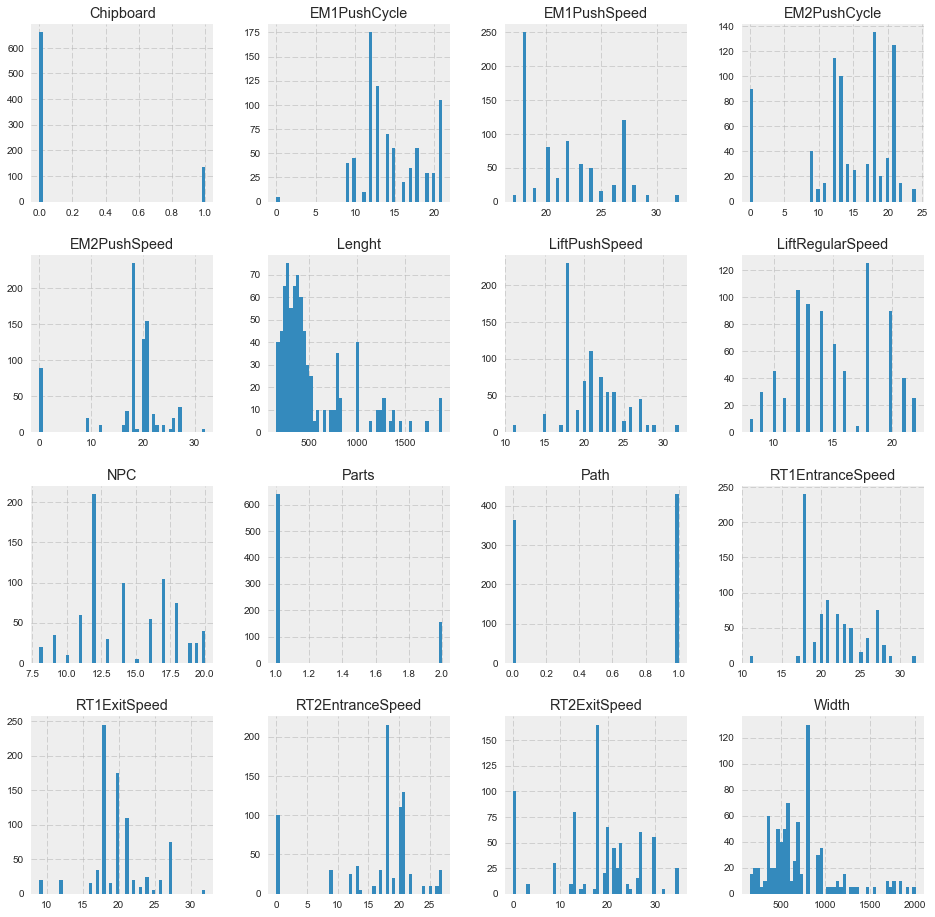

In [26]:
data[continuous + categorical + binary].hist(figsize=(16, 16), bins=50, xlabelsize=10, ylabelsize=10);

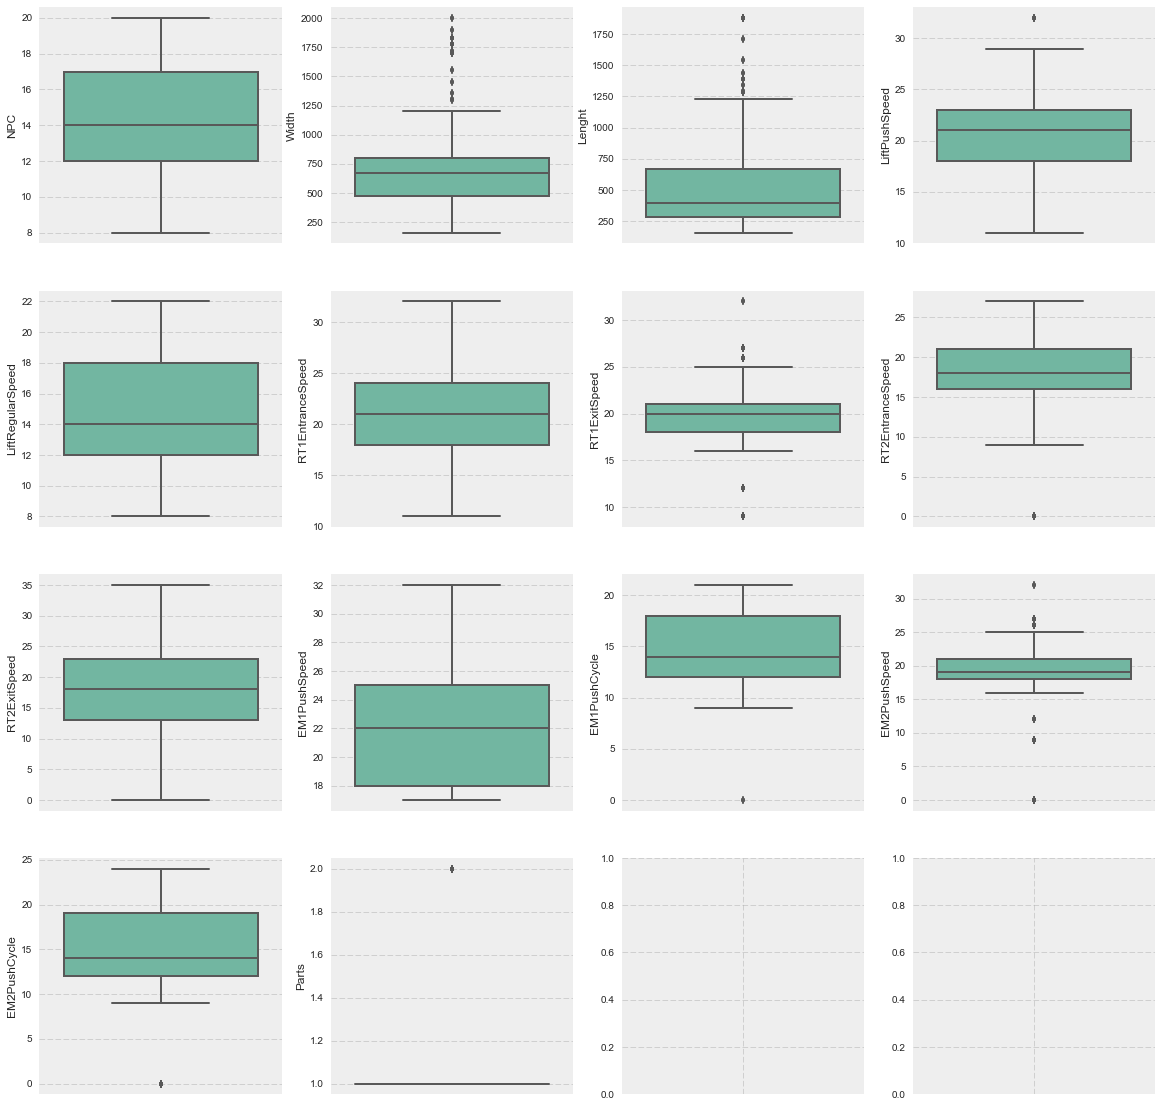

In [40]:
fig, axes = plt.subplots(4,4, figsize=(20,20), sharex=True)
axes = axes.flatten()

for ax, row in zip(axes, continuous):
    
    sns.boxplot(
                data=data,
                y=row,
                ax = ax,
                palette="Set2")

### Correlation

In [28]:
data.corr(method='pearson').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

C:\Users\banarn\AppData\Local\Continuum\Anaconda3\lib\site-packages\matplotlib\colors.py:494: RuntimeWarning: invalid value encountered in less
  cbook._putmask(xa, xa < 0.0, -1)


In [29]:
dataCorr = data.corr(method='pearson')
# viariant when matrix is diogonal
dataCorr = dataCorr.mask(np.tril(np.ones(dataCorr.shape)).astype(np.bool))

# when need all correlation items
dataCorr = dataCorr[abs(dataCorr) >= 0.7].stack().reset_index()

# when need just NPC correlation
# dataCorr = dataCorr.stack().reset_index()
# dataCorr = dataCorr[dataCorr.level_0 == 'NPC']
dataCorr

,level_0,level_1,0
0,LiftPushSpeed,RT1EntranceSpeed,0.886138
1,LiftPushSpeed,EM1PushSpeed,0.791935
2,LiftRegularSpeed,EM1PushCycle,0.747046
3,RT1EntranceSpeed,EM1PushSpeed,0.893575
4,RT2EntranceSpeed,RT2ExitSpeed,0.821149
5,RT2EntranceSpeed,EM2PushSpeed,0.896862
6,RT2EntranceSpeed,EM2PushCycle,0.846990
7,RT2ExitSpeed,EM2PushSpeed,0.744536
8,RT2ExitSpeed,EM2PushCycle,0.769564
9,EM2PushSpeed,EM2PushCycle,0.834963


**Įžvalgos:** duomenų porų pasiskirtymę visose porose įžvelgiamas tiesinis ryšys. *(Augant įėjimo greičiui auga ir išėjimo greitis kas riamentis ekspertine nuomuone yra pilnai suprantama)* Tiesinė priklausomybė įžvelgiama visose porose, skirtingi tik priklausomybės stiprumai tarp porų. 

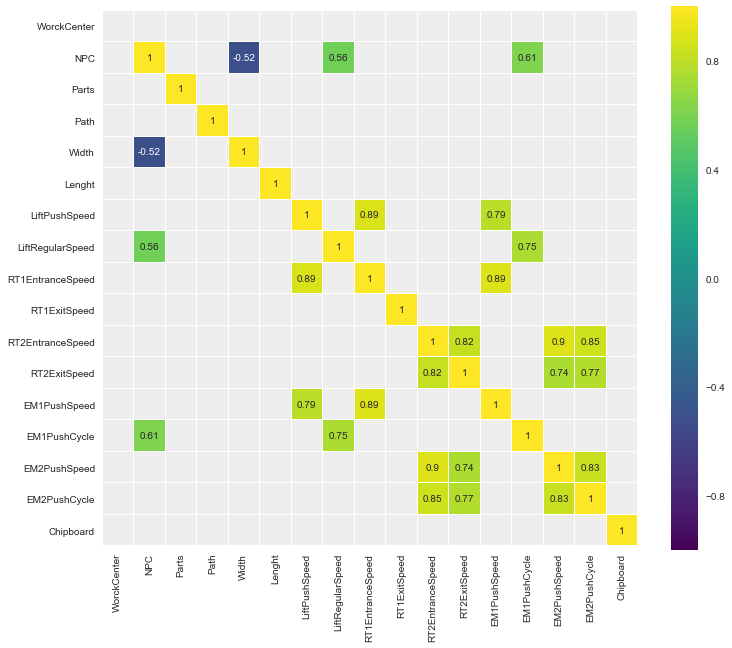

In [33]:
corr = data.corr(method='pearson') # We already examined SalePrice correlations
plt.figure(figsize=(12, 10))

p = sns.heatmap(corr[(corr >= 0.5) | (corr <= -0.4)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 10}, square=True);


Peržvelgus duomenis įžvelgiamos teigiamos korelecijos pilnai suprantamos remiantis tuo, kad charakterizuojami duomenys yra didžioji dalis apdirbimo linijos įvairių segmentų pastųmos greičiai *(Tarpusavio sasaja tiesinis ryšys)*. Įdomesnė neigiama korelecija tarp NPC *(detalių skaičius per minutę)* ir Width *(detalių pločio)*. Detalės plotis veikia neigiamai NPC t.y. kuo didesnis detalės plotis tuo mažesnis NPC

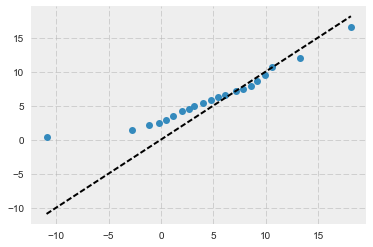

In [35]:
import numpy as np
import matplotlib.pyplot as plt

a = np.random.normal(5,5,250)
b = np.random.rayleigh(5,250)

percs = np.linspace(0,100,21)
qn_a = np.percentile(a, percs)
qn_b = np.percentile(b, percs)

plt.plot(qn_a,qn_b, ls="", marker="o")

x = np.linspace(np.min((qn_a.min(),qn_b.min())), np.max((qn_a.max(),qn_b.max())))
plt.plot(x,x, color="k", ls="--")

plt.show()

### QQ - Plot diagrama

Pandas(Index=0, level_0='LiftPushSpeed', level_1='RT1EntranceSpeed', _3=0.8861379014694838)
Pandas(Index=1, level_0='LiftPushSpeed', level_1='EM1PushSpeed', _3=0.7919350897568888)
Pandas(Index=2, level_0='LiftRegularSpeed', level_1='EM1PushCycle', _3=0.7470456971657755)
Pandas(Index=3, level_0='RT1EntranceSpeed', level_1='EM1PushSpeed', _3=0.893575101183272)
Pandas(Index=4, level_0='RT2EntranceSpeed', level_1='RT2ExitSpeed', _3=0.821148851324015)
Pandas(Index=5, level_0='RT2EntranceSpeed', level_1='EM2PushSpeed', _3=0.8968624846900631)
Pandas(Index=6, level_0='RT2EntranceSpeed', level_1='EM2PushCycle', _3=0.8469898574392515)
Pandas(Index=7, level_0='RT2ExitSpeed', level_1='EM2PushSpeed', _3=0.7445362896766896)
Pandas(Index=8, level_0='RT2ExitSpeed', level_1='EM2PushCycle', _3=0.7695635060238983)
Pandas(Index=9, level_0='EM2PushSpeed', level_1='EM2PushCycle', _3=0.8349625049716327)


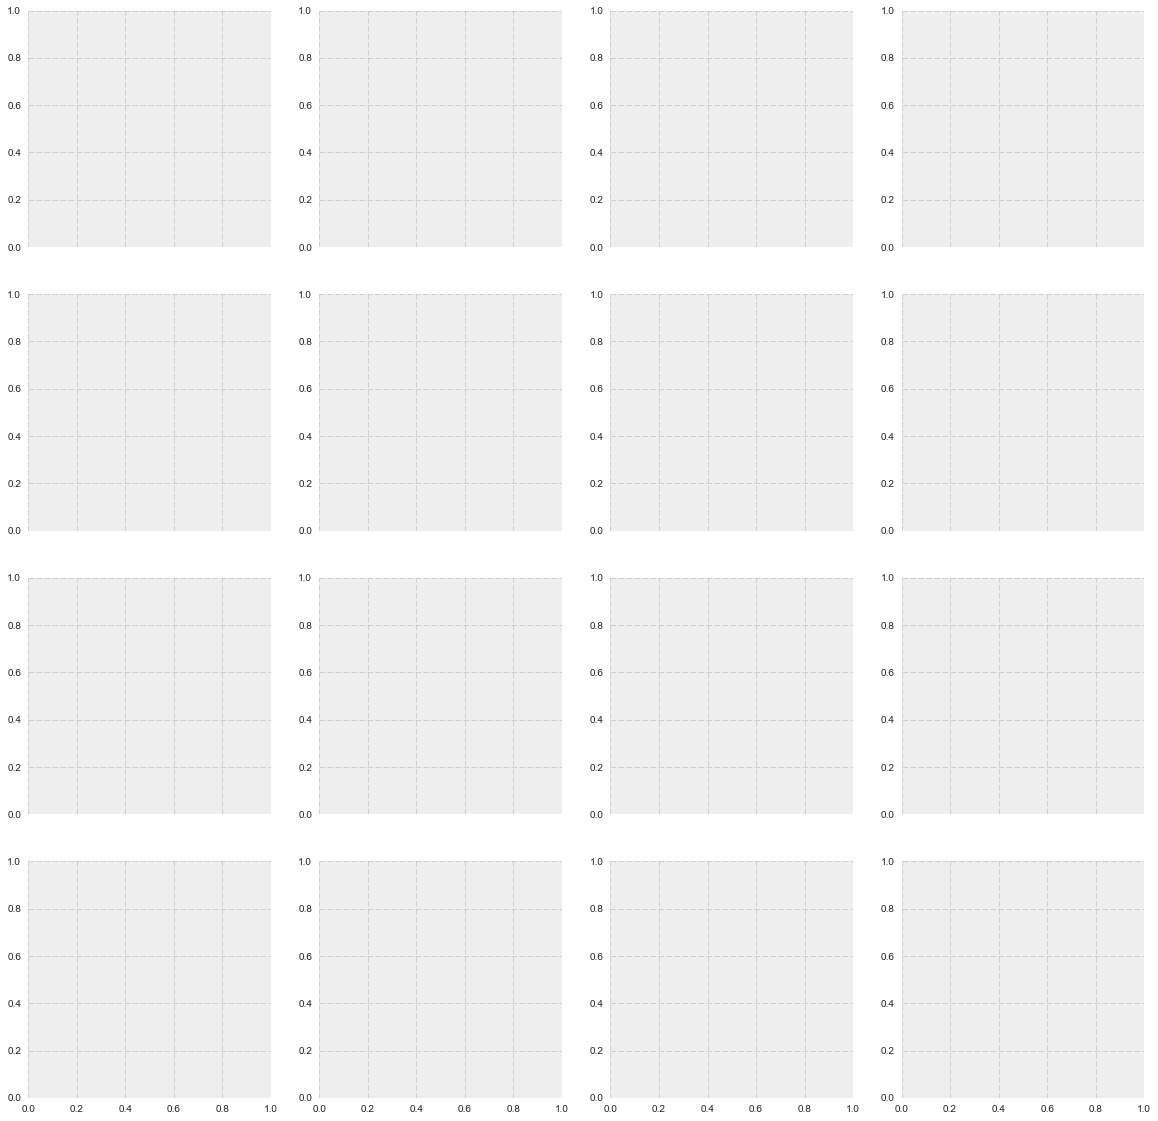

In [41]:
fig, axes = plt.subplots(4,4, figsize=(20,20), sharex=True)
axes = axes.flatten()

import probscale

for ax, row in zip(axes, dataCorr.itertuples(index=True, name= 'Pandas')):
    print (row)
#     probscale.probplot(df, ax=ax, bestfit=True, estimate_ci=True,
#                          line_kws={'label': 'BF Line', 'color': 'b'},
#                          scatter_kws={'label': 'Observations'},
#                          problabel='Probability (%)')
#     ax.legend(loc='lower right')
#     ax.set_ylim(bottom=-2, top=4)
#     seaborn.despine(fig)